In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
days_df = pd.read_csv(r"Data\load_profile\h0_seasons.csv", skiprows=1, sep=";", skipfooter=1, header=[0,1], encoding="utf8", decimal=",")
days_df.head()

C:\Users\febin\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


[W]  Winter                  Sommer                  \
  Unnamed: 0_level_1 Samstag Sonntag Werktag Samstag Sonntag Werktag   
0               0:15    70.8    87.5    67.6    89.8   100.1    86.3   
1               0:30    68.2    81.1    60.8    84.9    92.5    76.9   
2               0:45    65.9    75.0    54.9    80.7    85.9    68.8   
3               1:00    63.3    69.1    49.9    76.6    79.9    62.4   
4               1:15    59.5    63.4    46.2    71.7    74.1    58.0   

  Übergangszeit                  
        Samstag Sonntag Werktag  
0          80.2    93.4    77.8  
1          75.1    86.8    69.6  
2          70.7    81.2    62.4  
3          66.6    75.7    56.6  
4          62.3    70.1    52.5

In [3]:
# übergänge : sollten jeweils am 15. eines Monats sein
# 258->259 : Sommer -> Übergangszeit
# 305->306 : Übergangszeit -> Winter
# 79 ->80  : Winter -> Übergangszeit
# 134->135 : Übergang->Sommer
# Feiertage entsprechen Sonntagsverbrauch der jeweiligen Saison
slp_df = pd.DataFrame(pd.date_range("2017-01-01", periods=8760*4, freq="15min"), columns=["date"])
slp_df.loc[:, "dayOfYear"] = slp_df["date"].apply(lambda x: x.dayofyear)
slp_df.loc[:, "dayOfWeek"] = slp_df["date"].apply(lambda x: x.dayofweek) # monday=0, sunday=6
slp_df["demand"] = 0.0
slp_df.loc[[0,24*4,48*4],:]


,date,dayOfYear,dayOfWeek,demand
0,2017-01-01,1,6,0.0
96,2017-01-02,2,0,0.0
192,2017-01-03,3,1,0.0


In [4]:
# create indices
winter = (slp_df["dayOfYear"] > 305) |  (slp_df["dayOfYear"] < 80)
summer = (slp_df["dayOfYear"] > 134) |  (slp_df["dayOfYear"] < 259)
interm = ~(winter | summer)
assert (winter|summer|interm).sum()==365*24*4
is_weekday = slp_df["dayOfWeek"] < 5
is_sat = slp_df["dayOfWeek"] == 5
is_sun = slp_df["dayOfWeek"] == 6

In [5]:
feiertage_bnd= ["01. Jan 2017","14. Apr 2017","17. Apr 2017","01. May 2017","25. May 2017","05. Jun 2017","03. Oct 2017","31. Oct 2017","25. Dec 2017","26. Dec 2017"]
feiertage = pd.to_datetime(feiertage_bnd, format="%d. %b %Y")
is_celeb = np.in1d(slp_df["date"].apply(lambda x: x.date()),feiertage.date)


In [6]:
n_winter_weekdays = (winter&is_weekday).sum()
slp_df.loc[winter&is_weekday,"demand"] = days_df["Winter"]["Werktag"].to_list() * (n_winter_weekdays//96) # repeats the series

n_winter_saturdays= (winter&is_sat).sum()
slp_df.loc[winter&is_sat,"demand"] = days_df["Winter"]["Samstag"].to_list() * (n_winter_saturdays//96) # repeats the series

n_winter_sundays= (winter&(is_sun | is_celeb)).sum()
slp_df.loc[winter&(is_sun | is_celeb),"demand"] = days_df["Winter"]["Sonntag"].to_list() * (n_winter_sundays//96) # repeats the series


In [7]:
n_summer_weekdays = (summer&is_weekday).sum()
slp_df.loc[summer&is_weekday,"demand"] = days_df["Sommer"]["Werktag"].to_list() * (n_summer_weekdays//96) # repeats the series

n_summer_saturdays= (summer&is_sat).sum()
slp_df.loc[summer&is_sat,"demand"] = days_df["Sommer"]["Samstag"].to_list() * (n_summer_saturdays//96) # repeats the series

n_summer_sundays= (summer&(is_sun | is_celeb)).sum()
slp_df.loc[summer&(is_sun | is_celeb),"demand"] = days_df["Sommer"]["Sonntag"].to_list() * (n_summer_sundays//96) # repeats the series

In [8]:
n_interm_weekdays = (interm&is_weekday).sum()
slp_df.loc[interm&is_weekday,"demand"] = days_df["Übergangszeit"]["Werktag"].to_list() * (n_interm_weekdays//96) # repeats the series

n_interm_saturdays= (interm&is_sat).sum()
slp_df.loc[interm&is_sat,"demand"] = days_df["Übergangszeit"]["Samstag"].to_list() * (n_interm_saturdays//96) # repeats the series

n_interm_sundays= (interm&(is_sun | is_celeb)).sum()
slp_df.loc[interm&(is_sun | is_celeb),"demand"] = days_df["Übergangszeit"]["Sonntag"].to_list() * (n_interm_sundays//96) # repeats the series

In [9]:
# apply dynamicification
# see p. 19 of https://www.bdew.de/media/documents/2000131_Anwendung-repraesentativen_Lastprofile-Step-by-step.pdf

def dyn_func(t): return -3.92*10**-10 * t**4 + 3.2*10**-7 * t**3 - 7.02*10**-5* t**2 + 2.1*10**-3* t + 1.24
dynf = slp_df["date"].apply(lambda x: dyn_func(x.dayofyear))
slp_df["demand"] = slp_df["demand"] * dynf

In [10]:
slp_df.set_index("date",inplace=True)
slp_h0 = slp_df.resample("H").mean()["demand"]

In [11]:
#slp_h0.to_csv(r"Data\load_profile\h0_hourly_year.csv",encoding="utf8")

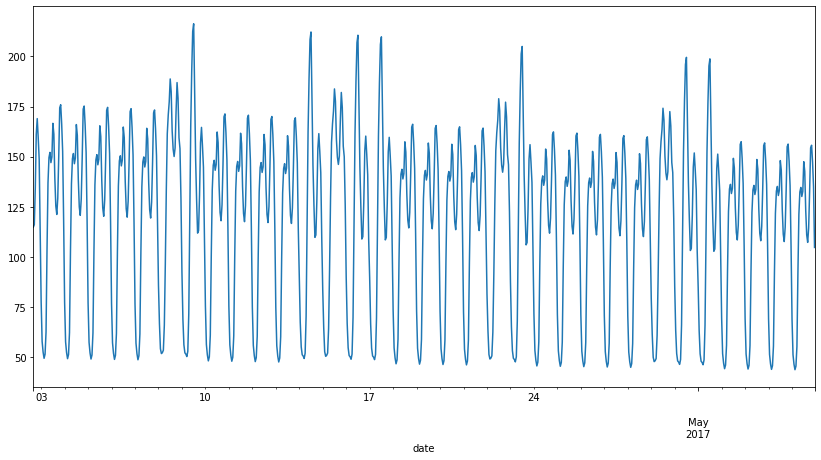

In [12]:
slp_h0.iloc[2200:3000].plot(figsize=(14,7)) # 14. April is equal to a sunday

In [13]:
hh_demand = pd.read_csv(r"Data\voll_calculated.csv", index_col="stat_bnd_amt_id")#, usecols=["NUTS", "geometry", "demand [MWh/a_2017]"])
# store bnd-id for column naming
id_colnames = [f"{int(bnd_id):05}" for bnd_id in hh_demand.index]
hh_demand.head()

,GEN,BEZ,NUTS,WSK,DEBKG_ID,geometry,population,population_m,population_w,brutto_mon_arbeitsort,brutto_mon_wohnort,demand [MWh/a_2017],Arbeitsstunden pro Arbeiter,wohnort stundenlohn,arbeitsort stundenlohn,Erwerbstätige,voll
stat_bnd_amt_id,,,,,,,,,,,,,,,,,
1001,Flensburg,Kreisfreie Stadt,DEF01,2008-01-01,DEBKGDL20000002R,"POLYGON ((9.412664108896104 54.8226409083269, ...",89504,44599,44905,2986.055556,2758.948276,137067.442378,1364,24.272272,26.270283,59876.0,22.359071
1002,Kiel,Kreisfreie Stadt,DEF02,2006-01-01,DEBKGDL20000E43X,"POLYGON ((10.16915818579685 54.43137670797367,...",247548,120566,126982,3303.962273,3148.856511,383927.889667,1370,27.581225,28.939816,171753.0,25.415788
1003,Lübeck,Kreisfreie Stadt,DEF03,2006-02-01,DEBKGDL20000DYM9,"POLYGON ((10.87683500018058 53.9873651861558, ...",217198,104371,112827,3035.921109,3022.366925,334958.088097,1388,26.129973,26.247157,128247.0,22.616154
1004,Neumünster,Kreisfreie Stadt,DEF04,1970-04-26,DEBKGDL20000E4KX,"POLYGON ((9.995446122384307 54.14971926107451,...",79487,39241,40246,2841.743194,2800.877644,122846.457156,1393,24.128163,24.480200,52372.0,21.702783
1051,Dithmarschen,Kreis,DEF05,2011-08-01,DEBKGDL20000E14G,MULTIPOLYGON (((9.0740249235541 54.36276991647...,133210,65720,67490,2913.626492,2971.936526,206636.303878,1393,25.601750,25.099439,60566.0,20.119030


In [14]:
hh_total_dem = hh_demand["demand [MWh/a_2017]"].sum()
hh_total_dem # closely matches https://www.destatis.de/EN/Themes/Society-Environment/Environment/Material-Energy-Flows/Tables/electricity-consumption-households.html


128200000.0

In [15]:
slp_h0_normed = slp_h0/slp_h0.sum()
slp_h0_normed.sum()

1.0

128199999.99999999

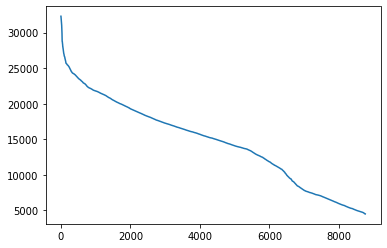

In [16]:
agg_h0_load =  slp_h0_normed * hh_total_dem
agg_h0_load.sort_values(ignore_index=True, ascending=False).plot()
agg_h0_load.sum()

In [17]:
#h_load_df

In [18]:
regional_hh_series = np.matmul(hh_demand["demand [MWh/a_2017]"].values.reshape((401,1)), slp_h0_normed.values.reshape((1,8760)))


In [19]:
regional_hh_series.sum()

128200000.00000001

In [20]:
hh_geo_demand_df = pd.DataFrame(regional_hh_series.T, columns=id_colnames)
hh_geo_demand_df

,01001,01002,01003,01004,01051,01053,01054,01055,01056,01057,...,16068,16069,16070,16071,16072,16073,16074,16075,16076,16077
0,14.588096,40.861469,35.649610,13.074556,21.992315,32.313361,27.268446,33.056618,51.527281,21.233402,...,11.540580,10.534630,17.935387,13.535342,9.288398,17.694447,13.676907,13.431517,16.360705,14.939289
1,10.851525,30.395278,26.518376,9.725660,16.359239,24.036669,20.283950,24.589549,38.329166,15.794713,...,8.584595,7.836307,13.341446,10.068421,6.909283,13.162220,10.173726,9.991190,12.170101,11.112764
2,8.869270,24.842952,21.674247,7.949067,13.370886,19.645874,16.578668,20.097759,31.327552,12.909482,...,7.016441,6.404843,10.904355,8.229216,5.647159,10.757868,8.315285,8.166092,9.946980,9.082788
3,8.238367,23.075785,20.132481,7.383622,12.419767,18.248394,15.399368,18.668134,29.099112,11.991185,...,6.517337,5.949244,10.128690,7.643843,5.245457,9.992623,7.723789,7.585209,9.239416,8.436697
4,8.136608,22.790758,19.883809,7.292421,12.266361,18.022994,15.209159,18.437550,28.739686,11.843072,...,6.436836,5.875760,10.003582,7.549428,5.180666,9.869196,7.628386,7.491519,9.125293,8.332489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,25.054364,70.177636,61.226515,22.454930,37.770758,55.496666,46.832264,56.773174,88.495663,36.467362,...,19.820400,18.092727,30.803177,23.246308,15.952383,30.389374,23.489439,23.067994,28.098736,25.657521
8756,26.273915,73.593617,64.206790,23.547951,39.609295,58.198033,49.111881,59.536676,92.803296,38.242454,...,20.785181,18.973412,32.302559,24.377850,16.728885,31.868613,24.632816,24.190856,29.466476,26.906432
8757,24.803038,69.473667,60.612337,22.229679,37.391870,54.939965,46.362478,56.203668,87.607941,36.101548,...,19.621576,17.911235,30.494183,23.013119,15.792361,30.084530,23.253811,22.836593,27.816870,25.400144
8758,23.105554,64.718991,56.464118,20.708313,34.832825,51.179954,43.189498,52.357171,81.612182,33.630811,...,18.278704,16.685416,28.407206,21.438135,14.711555,28.025589,21.662354,21.273690,25.913125,23.661795


In [21]:
# hh_geo_demand_df.to_csv(r"Data\load_profile\nuts3_hh_demand_profiles_dyn.csv")

In [22]:
geo_df = pd.read_csv("Data/netto_voll_calculated.csv")
geo_df["stat_bnd_amt_id"] = geo_df.stat_bnd_amt_id.apply(lambda x: f"{x:05}")
geo_df.set_index("stat_bnd_amt_id", inplace=True)

(array([ 8., 27., 15.,  8.,  3.,  4., 12., 19., 36., 41., 56., 51., 30.,
        19., 16., 15.,  9.,  8.,  5.,  4.,  3.,  2.,  4.,  1.,  2.,  1.,
         0.,  0.,  0.,  2.]),
 array([12.07836777, 12.72683005, 13.37529233, 14.02375461, 14.67221689,
        15.32067918, 15.96914146, 16.61760374, 17.26606602, 17.9145283 ,
        18.56299058, 19.21145286, 19.85991514, 20.50837742, 21.1568397 ,
        21.80530198, 22.45376426, 23.10222654, 23.75068882, 24.3991511 ,
        25.04761338, 25.69607566, 26.34453794, 26.99300022, 27.6414625 ,
        28.28992479, 28.93838707, 29.58684935, 30.23531163, 30.88377391,
        31.53223619]),
 <a list of 30 Patch objects>)

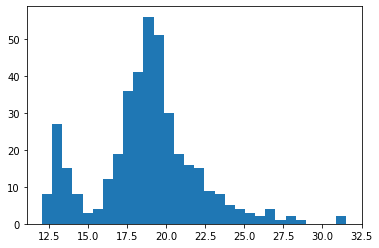

In [23]:
plt.hist(geo_df['voll'], bins=30)

In [24]:
geo_df['voll'].quantile(q=0.95)

12.925211152564636

In [25]:
geo_df[(geo_df['voll']<24.2) & (geo_df['voll']>23.8)].sort_values(by='voll')

,GEN,BEZ,NUTS,WSK,DEBKG_ID,geometry,stat_bnd_amt_id.1,population,population_m,population_w,brutto_mon_arbeitsort,brutto_mon_wohnort,demand [MWh/a_2017],Arbeitsstunden pro Arbeiter,wohnort stundenlohn,arbeitsort stundenlohn,Erwerbstätige,netto_mon_wohnort,wohnort nettolohn [€/h],voll
stat_bnd_amt_id,,,,,,,,,,,,,,,,,,,,
09162,München,Kreisfreie Stadt,DE212,2004-12-31,DEBKGDL20000E06K,"POLYGON ((11.54637124957018 48.22836101366191,...",9162,1471508,717308,754200,4168.697158,4005.184363,2.254607e+06,1422,33.799024,35.178879,1104722.0,3079.302891,25.985678,24.667107
05314,Bonn,Kreisfreie Stadt,DEA22,1969-08-01,DEBKGDL20000E68K,"POLYGON ((7.132213394039788 50.77185443739246,...",5314,327258,156328,170930,3857.376026,3711.785166,5.040057e+05,1374,32.417338,33.688874,247944.0,2952.653666,25.787368,24.802229
05111,Düsseldorf,Kreisfreie Stadt,DEA11,1980-01-01,DEBKGDL20000E3B7,"POLYGON ((6.752939467750587 51.34988271542953,...",5111,619294,299315,319979,3882.140137,3778.947752,9.558286e+05,1415,32.047613,32.922743,534147.0,2925.838240,24.812762,24.927271


In [26]:
#add correctly formatted timestamps for RE3ASON with time change
hourly_hh_demand_df = pd.read_csv(r"Data\load_profile\nuts3_hh_demand_profiles.csv")
id = hourly_hh_demand_df['Date']

In [27]:
hourly_volls = [geo_df["voll"][id] * hh_geo_demand_df[id]/ hh_geo_demand_df[id].mean() for id in hh_geo_demand_df.columns]

In [28]:
hourly_voll_df = pd.DataFrame(hourly_volls)
hourly_voll_df

,0,1,2,3,4,5,6,7,8,9,...,8750,8751,8752,8753,8754,8755,8756,8757,8758,8759
01001,17.419043,12.957358,10.590428,9.837094,9.715588,9.482297,9.978040,13.511423,21.861288,31.154037,...,28.351933,24.475250,21.326675,21.557899,24.922938,29.916381,31.372597,29.616283,27.589388,21.267639
01002,19.790966,14.721740,12.032510,11.176595,11.038544,10.773486,11.336734,15.351252,24.838105,35.396232,...,32.212570,27.808006,24.230694,24.493403,28.316655,33.990047,35.644553,33.649084,31.346190,24.163620
01003,17.600351,13.092226,10.700660,9.939484,9.816714,9.580995,10.081898,13.652058,22.088834,31.478307,...,28.647037,24.730003,21.548656,21.782286,25.182351,30.227769,31.699142,29.924547,27.876555,21.489006
01004,17.206123,12.798975,10.460977,9.716851,9.596830,9.366391,9.856075,13.346268,21.594069,30.773228,...,28.005376,24.176079,21.065991,21.294388,24.618295,29.550701,30.989117,29.254271,27.252151,21.007677
01051,15.782764,11.740192,9.595604,8.913034,8.802942,8.591566,9.040741,12.242211,19.807721,28.227544,...,25.688659,22.176138,19.323328,19.532831,22.581771,27.106149,28.425574,26.834241,24.997745,19.269838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16073,12.520753,9.313707,7.612366,7.070871,6.983534,6.815845,7.172183,9.711968,15.713824,22.393422,...,20.379279,17.592731,15.329546,15.495749,17.914528,21.503799,22.550522,21.288089,19.831163,15.287111
16074,12.054470,8.966857,7.328875,6.807546,6.723461,6.562017,6.905085,9.350286,15.128628,21.559473,...,19.620338,16.937564,14.758661,14.918674,17.247377,20.702980,21.710723,20.495303,19.092635,14.717807
16075,11.826455,8.797246,7.190247,6.678780,6.596285,6.437895,6.774474,9.173423,14.842466,21.151668,...,19.249213,16.617184,14.479496,14.636483,16.921137,20.311377,21.300057,20.107628,18.731492,14.439415
16076,11.260993,8.376620,6.846457,6.359444,6.280894,6.130077,6.450563,8.734810,14.132797,20.140335,...,18.328843,15.822661,13.787183,13.936663,16.112080,19.340221,20.281629,19.146214,17.835875,13.749017


In [29]:
hourly_voll_df = hourly_voll_df.T.set_index(id)
hourly_voll_df

,01001,01002,01003,01004,01051,01053,01054,01055,01056,01057,...,16068,16069,16070,16071,16072,16073,16074,16075,16076,16077
Date,,,,,,,,,,,,,,,,,,,,,
01.01.2017 00:00,17.419043,19.790966,17.600351,17.206123,15.782764,15.703666,14.851709,15.411175,16.534088,16.105180,...,11.902494,11.971721,12.396722,12.381115,12.836604,12.520753,12.054470,11.826455,11.260993,11.449180
01.01.2017 01:00,12.957358,14.721740,13.092226,12.798975,11.740192,11.681354,11.047616,11.463782,12.299073,11.980025,...,8.853809,8.905303,9.221445,9.209836,9.548657,9.313707,8.966857,8.797246,8.376620,8.516605
01.01.2017 02:00,10.590428,12.032510,10.700660,10.460977,9.595604,9.547513,9.029541,9.369685,10.052393,9.791626,...,7.236477,7.278566,7.536958,7.527469,7.804397,7.612366,7.328875,7.190247,6.846457,6.960871
01.01.2017 03:00,9.837094,11.176595,9.939484,9.716851,8.913034,8.868365,8.387238,8.703186,9.337331,9.095113,...,6.721721,6.760815,7.000827,6.992014,7.249243,7.070871,6.807546,6.678780,6.359444,6.465720
01.01.2017 04:00,9.715588,11.038544,9.816714,9.596830,8.802942,8.758825,8.283640,8.595686,9.221998,8.982772,...,6.638696,6.677307,6.914355,6.905650,7.159702,6.983534,6.723461,6.596285,6.280894,6.385857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31.12.2017 19:00,29.916381,33.990047,30.227769,29.550701,27.106149,26.970301,25.507107,26.467963,28.396512,27.659882,...,20.441970,20.560863,21.290782,21.263978,22.046258,21.503799,20.702980,20.311377,19.340221,19.663423
31.12.2017 20:00,31.372597,35.644553,31.699142,30.989117,28.425574,28.283113,26.748696,27.756323,29.778747,29.006261,...,21.437007,21.561687,22.327137,22.299028,23.119386,22.550522,21.710723,21.300057,20.281629,20.620564
31.12.2017 21:00,29.616283,33.649084,29.924547,29.254271,26.834241,26.699755,25.251239,26.202457,28.111660,27.382419,...,20.236912,20.354611,21.077209,21.050674,21.825107,21.288089,20.495303,20.107628,19.146214,19.466175


In [30]:
hourly_voll_df[2015:7228]

,01001,01002,01003,01004,01051,01053,01054,01055,01056,01057,...,16068,16069,16070,16071,16072,16073,16074,16075,16076,16077
Date,,,,,,,,,,,,,,,,,,,,,
25.03.2017 23:00,21.290594,24.189700,21.512199,21.030350,19.290636,19.193957,18.152645,18.836458,20.208949,19.684711,...,14.547939,14.632551,15.152013,15.132937,15.689663,15.303611,14.733692,14.454999,13.763857,13.993870
26.03.2017 00:00,15.249881,17.326433,15.408611,15.063476,13.817365,13.748116,13.002253,13.492050,14.475128,14.099631,...,10.420298,10.480904,10.852981,10.839317,11.238085,10.961566,10.553348,10.353728,9.858682,10.023434
26.03.2017 01:00,11.343801,12.888468,11.461874,11.205141,10.278207,10.226696,9.671877,10.036218,10.767492,10.488174,...,7.751260,7.796342,8.073116,8.062952,8.359580,8.153888,7.850231,7.701741,7.333495,7.456048
26.03.2017 03:00,9.271622,10.534123,9.368126,9.158291,8.400680,8.358579,7.905108,8.202895,8.800587,8.572292,...,6.335332,6.372179,6.598394,6.590087,6.832530,6.664412,6.416224,6.294859,5.993880,6.094047
26.03.2017 04:00,8.612098,9.784794,8.701738,8.506829,7.803110,7.764003,7.342790,7.619394,8.174570,7.962515,...,5.884677,5.918903,6.129027,6.121311,6.346508,6.190349,5.959815,5.847083,5.567514,5.660555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29.10.2017 00:00,19.917662,22.629818,20.124977,19.674201,18.046672,17.956228,16.982065,17.621782,18.905767,18.415336,...,13.609810,13.688966,14.174930,14.157084,14.677909,14.316752,13.783584,13.522864,12.876290,13.091471
29.10.2017 01:00,14.374026,16.331315,14.523640,14.198327,13.023785,12.958513,12.255487,12.717153,13.643770,13.289839,...,9.821824,9.878948,10.229655,10.216777,10.592641,10.332004,9.947232,9.759077,9.292462,9.447753
29.10.2017 02:00,10.692286,12.148238,10.803578,10.561590,9.687893,9.639341,9.116386,9.459802,10.149077,9.885801,...,7.306077,7.348570,7.609448,7.599868,7.879459,7.685581,7.399364,7.259403,6.912306,7.027820


In [31]:
#hourly_voll_df.to_csv(r"Data\geo_temporal_h0_voll.csv")
#hourly_voll_df.to_csv(r"Data\ts_voll.csv", sep=';', decimal=',')